# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [25]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
38,p26377723i,Hyundai Solaris,economy,petrol,4.10,2013,40281,2019,32.46,break_bug
1782,i99395396b,Audi A4,premium,petrol,3.62,2014,65850,2021,58.55,break_bug
2219,j22108372p,Renault Sandero,standart,petrol,4.08,2015,88751,2017,29.55,gear_stick
1410,L-8838271K,Kia Rio X-line,economy,petrol,4.88,2013,42058,2014,41.24,engine_fuel
1795,K-9603888y,Skoda Rapid,economy,petrol,5.94,2017,116891,2022,57.69,engine_ignition


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [26]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
355293,P21225453K,Z11671085y,Y1L,2020-03-25,4.74,7,71,51,116.000000,0,285.648709,0,-15.993535,53.249
478623,R74583173w,h20080273C,x1O,2020-03-06,5.19,32,377,42,104.000000,0,1251.702650,0,-8.809177,-7.950
263945,W12843451v,S-7977049s,H1e,2020-03-26,4.14,90,715,48,160.184935,1,3267.168708,0,-28.059213,-16.473
660110,X77202092O,u14638117A,e1E,2020-03-08,2.41,85,674,38,67.000000,2,2427.649834,0,-17.406167,16.069
529500,X11180141G,l-4285389z,k1r,2020-01-10,5.67,15,235,28,61.420499,0,296.094907,0,6.844954,-24.115


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [27]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
4756,21,8.6,1112,7.0,N22609412O,1,2020-12-3
13733,23,7.6,1697,11.0,L75947865P,1,2018-5-26
11686,29,8.2,1685,15.0,R27836906x,1,2018-6-2
9664,37,8.2,1340,3.0,K17921479u,0,2021-4-26
8205,44,8.3,759,3.0,Y94647179w,0,2020-8-28


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [28]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
59857,i-1101173g,PB,2020-3-20 2:58,repair,6.1,27
15692,O-2154805o,YS,2019-5-5 22:53,reparking,1.0,23
45971,d-5044364D,PN,2021-8-23 4:6,reparking,1.0,22
52778,K91014117o,BZ,2020-4-10 10:6,reparking,1.0,30
88655,w-1350890O,PY,2020-4-6 1:32,repair,5.0,37


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [ ]:
# # Пример расчета одного признака
# rides_info.groupby('car_id', as_index=False).agg(
#     mean_rating = ('rating', 'mean'),
#     # ... еще признаки
# )

# df = pd.merge(...) # Соедините полученный датасет с фичами с основным датасетом

# # YOUR CODE HERE

In [29]:
rides_info = pd.merge(rides_info, driver_info, on='user_id', how='left')
rides_info

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909,18,8.0,228,9.0,1,2019-9-16
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133,40,7.0,992,9.0,0,2019-2-26
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461,32,7.7,1646,3.0,1,2018-6-11
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909,35,7.7,1899,8.0,0,2021-9-22
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822,24,7.6,472,1.0,1,2019-7-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739495,I15732675M,z91796444U,m1z,2020-03-30,7.42,164,2290,49,54.586302,0,2274.772387,0,6.137593,-39.752,39,7.3,817,3.0,0,2019-4-13
739496,r51579957X,z91796444U,t1P,2020-03-30,4.19,26,412,46,73.000000,0,515.580231,0,6.703367,-38.480,33,8.0,357,13.0,1,2020-5-15
739497,l15212727I,z91796444U,z1A,2020-03-31,3.40,23,178,37,71.000000,1,444.846677,0,6.255344,-45.080,18,7.6,1065,8.0,1,2020-11-19
739498,Z78949958q,z91796444U,w1R,2020-04-01,9.02,5,75,48,87.000000,1,179.464361,0,7.759949,-60.193,34,7.9,301,6.0,0,2019-8-26


In [30]:
rides_info_grouped = rides_info.groupby('car_id').agg(
    min_rating=('rating', 'min'),
    avg_rating=('rating', 'mean'),
    max_rating=('rating', 'max'),
    total_distance=('distance', 'sum'),
    max_speed=('speed_max', 'max'),
    total_rides=('ride_id', 'count'),
    avg_user_rating=('user_rating', 'mean'),
    max_user_rating=('user_rating', 'max'),
    min_user_rating=('user_rating', 'min'),
    total_accidents_per_user=('user_time_accident', 'count'),
    avg_accidents_per_user=('user_time_accident', 'mean'),
    max_accidents_per_user=('user_time_accident', 'max'),
    min_accidents_per_user=('user_time_accident', 'min'),
).reset_index()
rides_info_grouped.head()

,car_id,min_rating,avg_rating,max_rating,total_distance,max_speed,total_rides,avg_user_rating,max_user_rating,min_user_rating,total_accidents_per_user,avg_accidents_per_user,max_accidents_per_user,min_accidents_per_user
0,A-1049127W,0.1,4.255172,9.53,1.125753e+07,179.729652,174,7.817816,9.4,6.1,174,9.298851,25.0,0.0
1,A-1079539w,0.1,4.088046,9.81,1.912765e+07,184.505566,174,7.773563,9.3,6.3,174,8.959770,22.0,0.0
2,A-1162143G,0.1,4.662299,9.15,2.995194e+06,180.000000,174,8.149425,10.0,6.5,125,17.736000,82.0,0.0
3,A-1228282M,0.1,4.225172,9.36,1.793685e+07,182.446070,174,8.045402,9.8,6.2,174,7.936782,22.0,0.0
4,A-1339912r,0.1,4.690115,9.97,1.202552e+07,152.000000,174,8.195402,9.8,6.2,117,18.051282,85.0,0.0


In [31]:
car_train_merged = pd.merge(car_train, rides_info_grouped, on='car_id', how='left')
car_train_merged.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,total_distance,max_speed,total_rides,avg_user_rating,max_user_rating,min_user_rating,total_accidents_per_user,avg_accidents_per_user,max_accidents_per_user,min_accidents_per_user
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,1.214131e+07,180.855726,174,8.229885,9.8,6.2,116,17.724138,77.0,0.0
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,1.803909e+07,187.862734,174,7.988506,9.8,6.7,174,6.965517,23.0,0.0
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,1.588366e+07,102.382857,174,7.843103,9.5,6.2,174,9.775862,25.0,0.0
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,1.651883e+07,172.793237,174,8.524138,10.0,8.0,115,19.991304,86.0,0.0
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,1.398317e+07,203.462289,174,8.112069,10.0,6.5,120,15.758333,72.0,0.0


In [32]:
fix_info_grouped = fix_info.groupby('car_id').agg(
    avg_work_duration=('work_duration', 'mean'),
    max_work_duration=('work_duration', 'max'),
    min_work_duration=('work_duration', 'min'),
    avg_destroy_degree=('destroy_degree', 'mean'),
    max_destroy_degree=('destroy_degree', 'max'),
    min_destroy_degree=('destroy_degree', 'min'),
).reset_index()

car_train_merged = pd.merge(car_train_merged, fix_info_grouped, on='car_id', how='left')
car_train_merged.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,total_accidents_per_user,avg_accidents_per_user,max_accidents_per_user,min_accidents_per_user,avg_work_duration,max_work_duration,min_work_duration,avg_destroy_degree,max_destroy_degree,min_destroy_degree
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,116,17.724138,77.0,0.0,26.657143,56,7,3.048571,9.0,1.0
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,174,6.965517,23.0,0.0,24.942857,48,4,2.917143,10.0,1.0
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,174,9.775862,25.0,0.0,26.142857,59,1,3.740000,10.0,1.0
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,115,19.991304,86.0,0.0,28.771429,64,1,4.085714,10.0,1.0
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,120,15.758333,72.0,0.0,28.028571,65,10,3.880000,10.0,1.0


### Идеи для новых признаков

1.   Новый пункт
2.   Новый пункт



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

## 1. Линейная корреляция

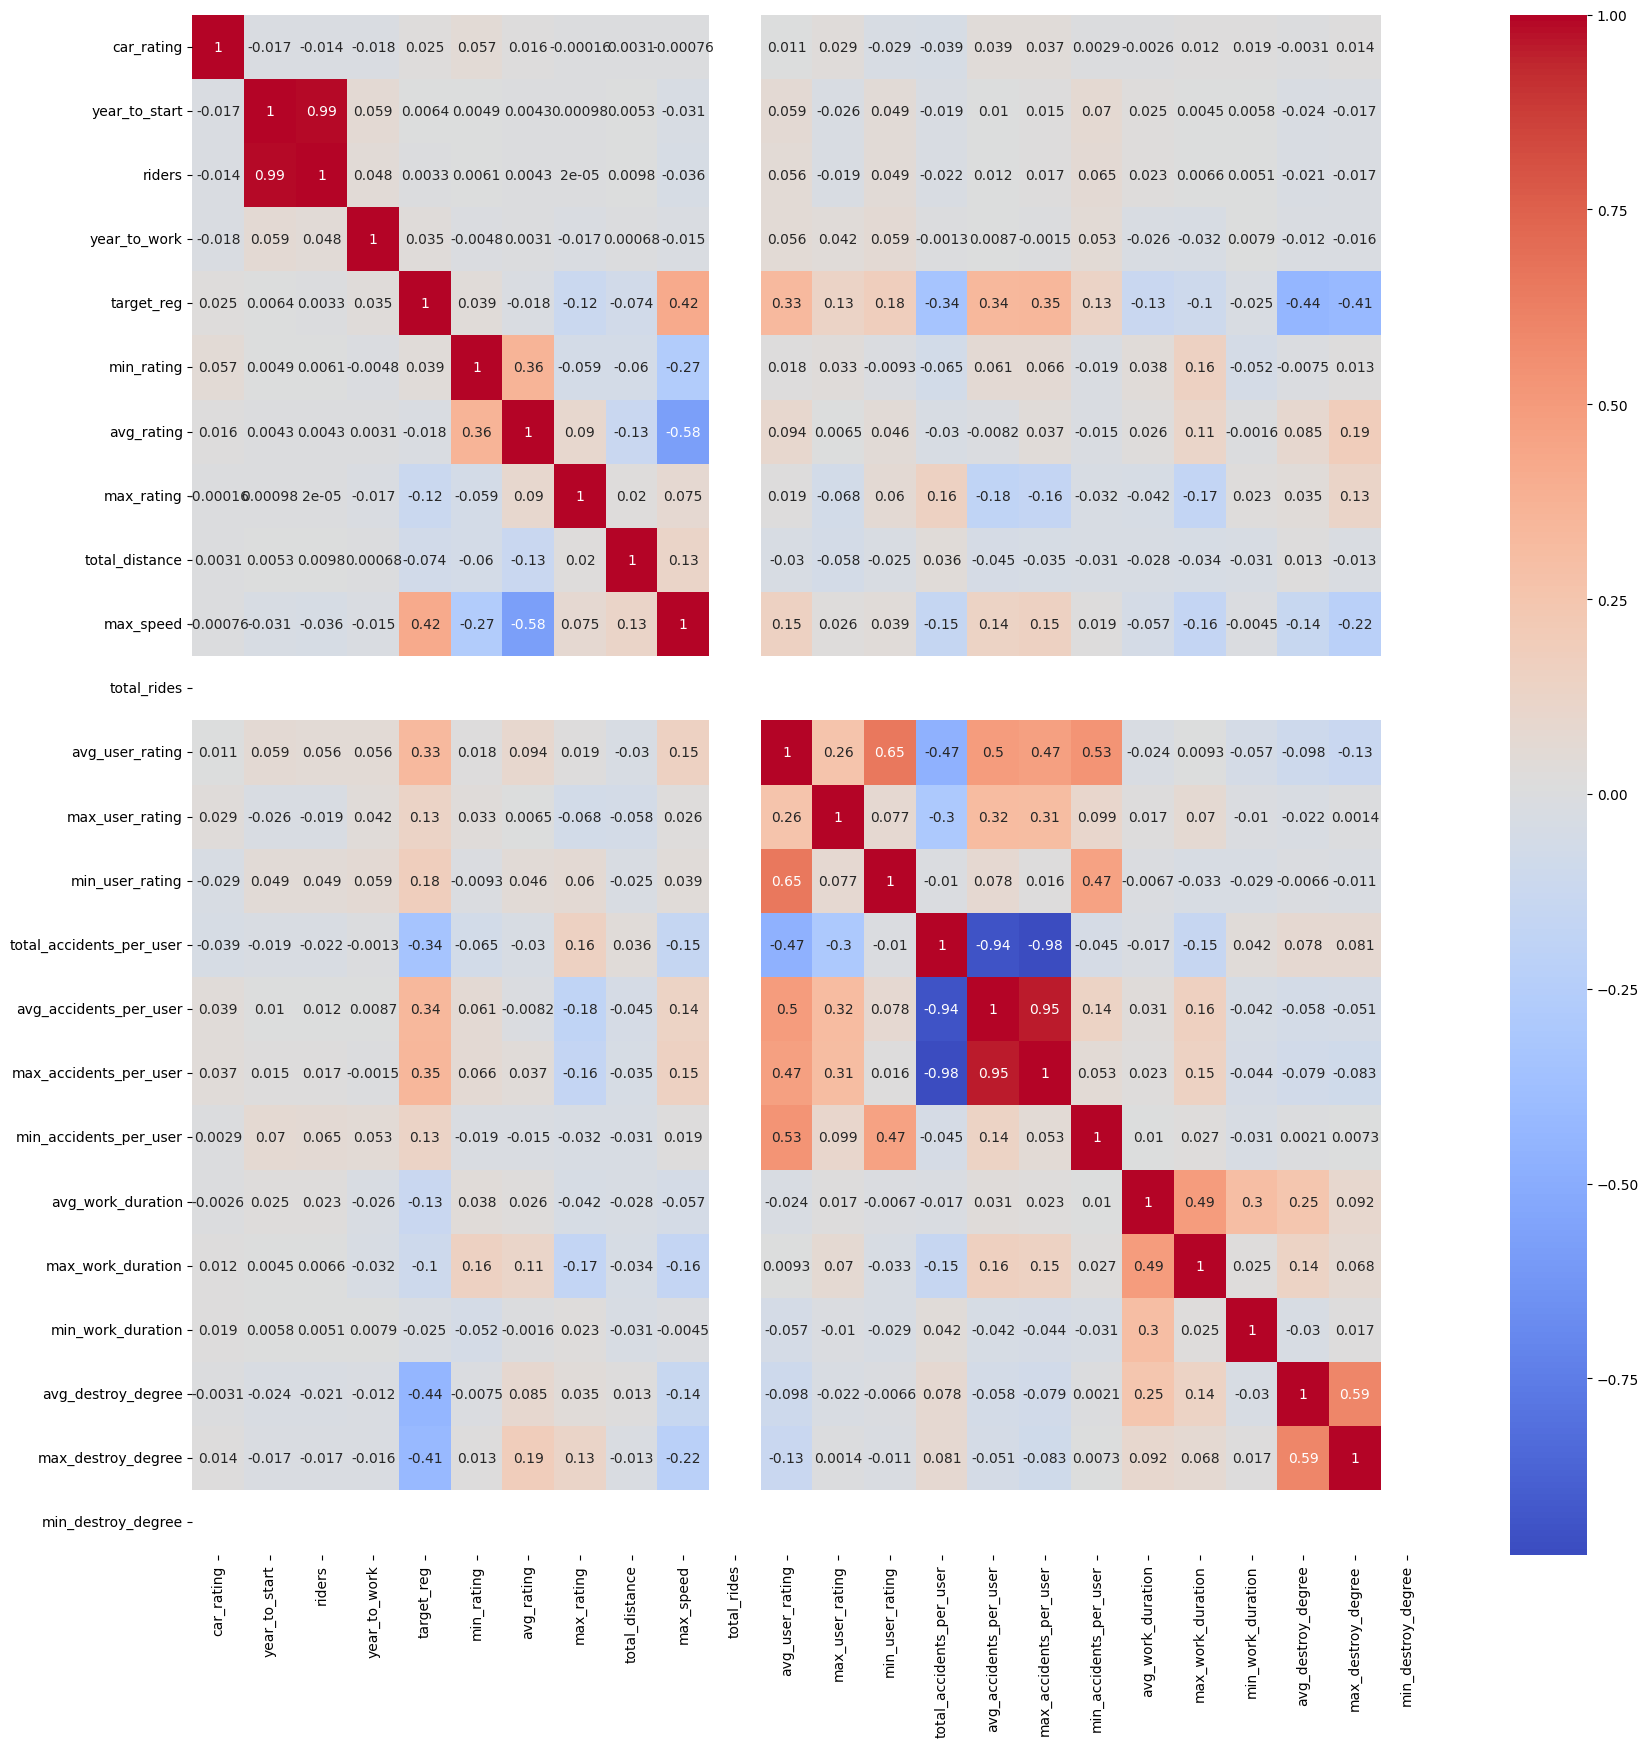

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = car_train_merged.select_dtypes(include=[np.number]).columns
correlation_matrix = car_train_merged[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()


## 2. Permutation Importance

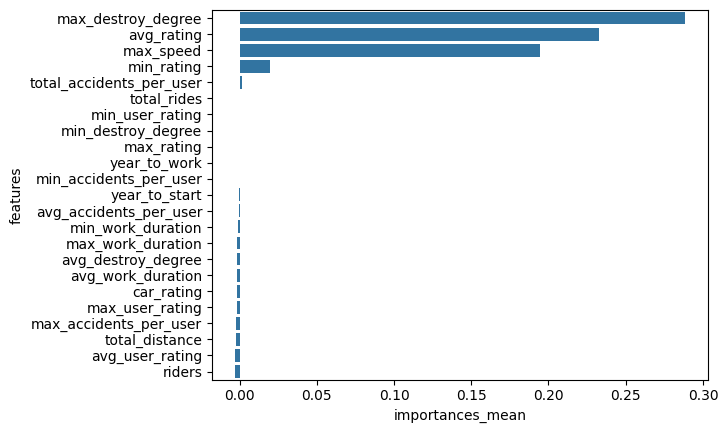

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

X = car_train_merged[numeric_cols]
X.pop('target_reg')
y = car_train_merged['target_class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
df_importances_mean = pd.DataFrame(
                        data=list(zip(result.importances_mean, X.columns)),
                        columns=['importances_mean', 'features']).sort_values(
                                        by='importances_mean', ascending=False)

sns.barplot(x=df_importances_mean['importances_mean'], y=df_importances_mean['features'])
plt.show()

## 3. SHAP

In [ ]:
!pip install shap -q

In [ ]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test.iloc[0])


![](https://github.com/rufous86/mipt_semester4/blob/main/competitive_ds/assets/shap_res.png?raw=1)

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `y` таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [35]:
!pip install catboost -q

In [36]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [37]:
df_importances_mean[df_importances_mean['importances_mean'] <= 0]['features'].tolist()

['total_rides',
 'min_user_rating',
 'min_destroy_degree',
 'max_rating',
 'year_to_work',
 'min_accidents_per_user',
 'year_to_start',
 'avg_accidents_per_user',
 'min_work_duration',
 'max_work_duration',
 'avg_destroy_degree',
 'avg_work_duration',
 'car_rating',
 'max_user_rating',
 'max_accidents_per_user',
 'total_distance',
 'avg_user_rating',
 'riders']

In [38]:
df_importances_mean[df_importances_mean['importances_mean'] > 0]['features'].tolist()

['max_destroy_degree',
 'avg_rating',
 'max_speed',
 'min_rating',
 'total_accidents_per_user']

In [39]:
car_train_merged.select_dtypes(include=['object']).columns

Index(['car_id', 'model', 'car_type', 'fuel_type', 'target_class'], dtype='object')

In [40]:
features2drop = [
    'total_rides',
    'min_user_rating',
    'min_destroy_degree',
    'max_rating',
    'year_to_work',
    'min_accidents_per_user',
    'year_to_start',
    'avg_accidents_per_user',
    'min_work_duration',
    'max_work_duration',
    'avg_destroy_degree',
    'avg_work_duration',
    'car_rating',
    'max_user_rating',
    'max_accidents_per_user',
    'total_distance',
    'avg_user_rating',
    'riders',
    'car_id'
    ] # то, что надо выбросить

targets = ['target_class'] # таргеты
cat_features = ['model', 'car_type', 'fuel_type'] # категориальные признаки

num_features = [
    'max_destroy_degree',
    'avg_rating',
    'max_speed',
    'min_rating',
    'total_accidents_per_user'
] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 3 ['model', 'car_type', 'fuel_type']
Числовые признаки: 5 ['max_destroy_degree', 'avg_rating', 'max_speed', 'min_rating', 'total_accidents_per_user']
Целевые переменные ['target_class']


In [41]:
# YOUR CODE HERE
# YOUR CODE HERE
X = car_train_merged[num_features+cat_features].drop(features2drop, axis=1, errors="ignore")
y = car_train_merged[targets]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = CatBoostClassifier(thread_count=-1,
                         random_seed=42,
                         cat_features=cat_features)

clf.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

y_pred = clf.predict(X_test, prediction_type='Class')
print('accuracy:', accuracy_score(y_test, y_pred))

Learning rate set to 0.109335
0:	learn: 1.7115572	test: 1.7094573	best: 1.7094573 (0)	total: 37.4ms	remaining: 37.3s
200:	learn: 0.0236301	test: 0.0509749	best: 0.0507846 (197)	total: 6.53s	remaining: 26s
400:	learn: 0.0107460	test: 0.0485416	best: 0.0480115 (346)	total: 12.7s	remaining: 18.9s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.04801150562
bestIteration = 346

Shrink model to first 347 iterations.
accuracy: 0.9871794871794872


# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [42]:
# YOUR CODE HERE
clf.get_feature_importance(prettified=True)

,Feature Id,Importances
0,total_accidents_per_user,29.158346
1,max_destroy_degree,23.654901
2,max_speed,18.431958
3,avg_rating,16.277508
4,min_rating,8.960065
5,model,2.330494
6,car_type,1.164471
7,fuel_type,0.022258


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.